In [1]:
import psycopg2 as ppg
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
import datetime
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
con = ppg.connect(dbname="tweets", user="patrick")

In [3]:
con.rollback()
with con.cursor() as cur:
    cur.execute("select user_id, max(tweets.created_at) as tweet_time, "
                "usr.created_at, last_tweet_at, (last_tweet_at < '2015-05-15') as churn, "
                "sum(atmention::int::float) / count(1)::float as atmention_rate, count(1) as num_tweets_user, "
                "usr.followers_count, usr.friends_count from tweets inner join "
                "(select user_id, name, followers_count, friends_count, last_tweet_at, created_at from users "
                "where last_tweet_at is not null) as usr using (user_id) "
                "where tweets.created_at < '2015-04-04' group by user_id, usr.created_at, "
                "usr.last_tweet_at, usr.followers_count, usr.friends_count order by usr.created_at;")
    churn_df = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])

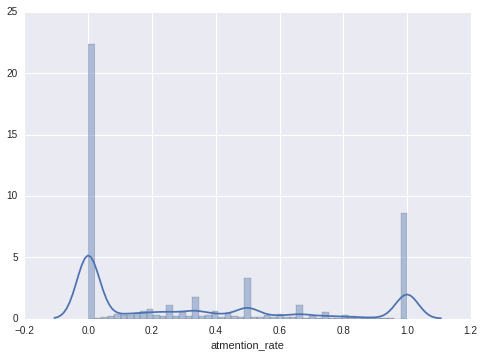

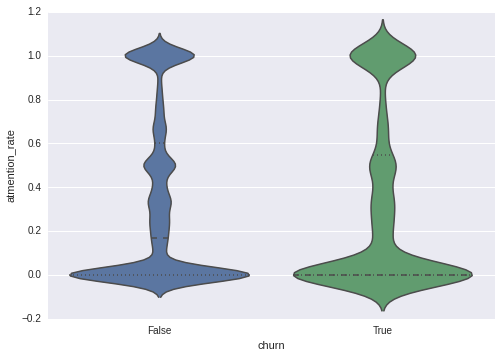

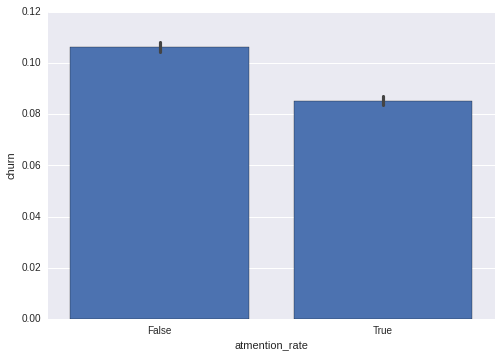

In [4]:
# at mention rate 
import seaborn as sns
plt.figure(1)
sns.distplot(churn_df.atmention_rate.replace([np.inf, -np.inf, np.nan], 0)+0.000)
plt.figure(2)
sns.violinplot(churn_df.atmention_rate.replace([np.inf, -np.inf, np.nan], 0), groupby=churn_df.churn)
plt.figure(3)
sns.barplot(x=churn_df.atmention_rate > 0, y=churn_df.churn, estimator=np.mean)



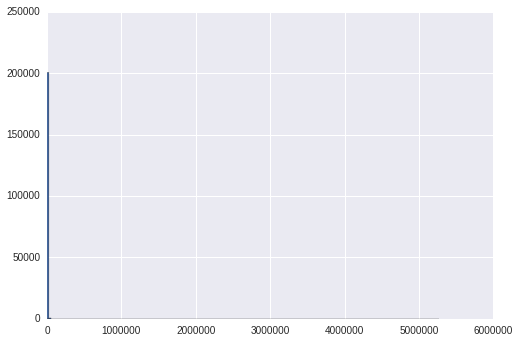

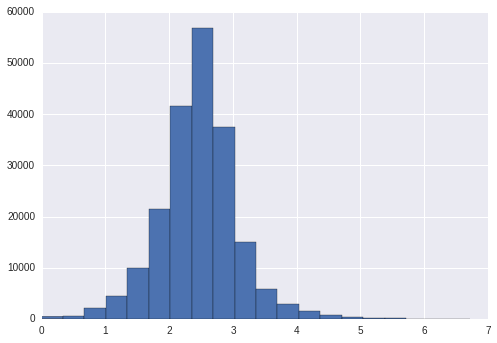

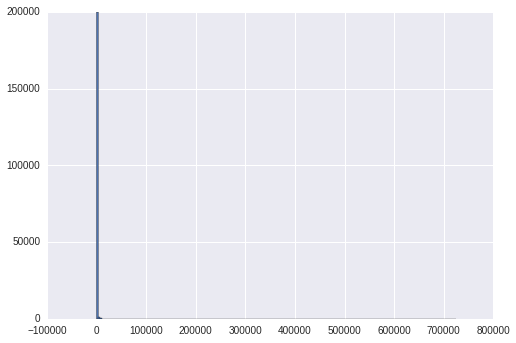

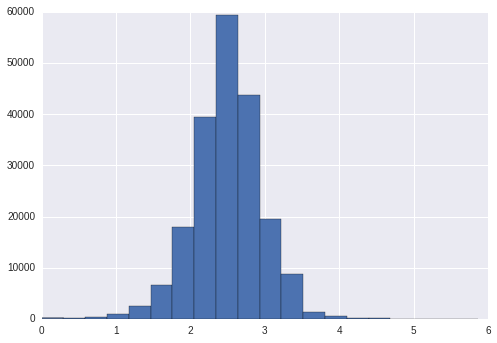

In [7]:

lgbase = 10
query_date = pd.to_datetime(datetime.datetime.strptime("2015-06-17", "%Y-%m-%d"))

churn_df['log_followers'] = (churn_df.followers_count + 1).map(lambda x: np.log(x) / np.log(lgbase)).replace([np.inf, -np.inf], np.nan)
churn_df['log_friends'] = (churn_df.friends_count + 1).map(lambda x: np.log(x) / np.log(lgbase)).replace([np.inf, -np.inf], np.nan)
churn_df['user_age'] = (query_date - churn_df.created_at).astype(np.int64)

plt.figure(1)
churn_df.followers_count.hist(bins=200)
plt.figure(2)
churn_df.log_followers.hist(bins=20)
plt.figure(3)
churn_df.friends_count.hist(bins=200)
plt.figure(4)
churn_df.log_friends.hist(bins=20)
plt.figure(5)


(201809, 13)


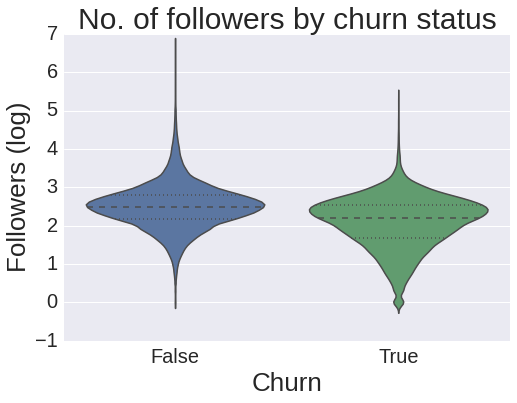

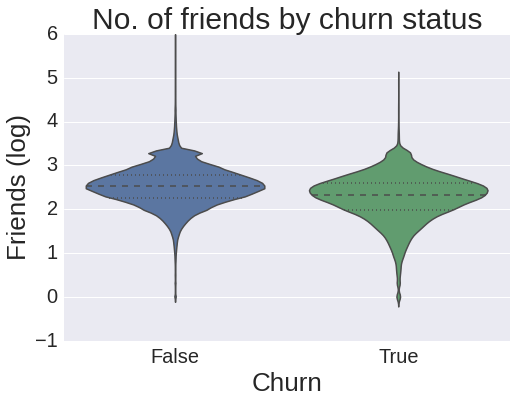

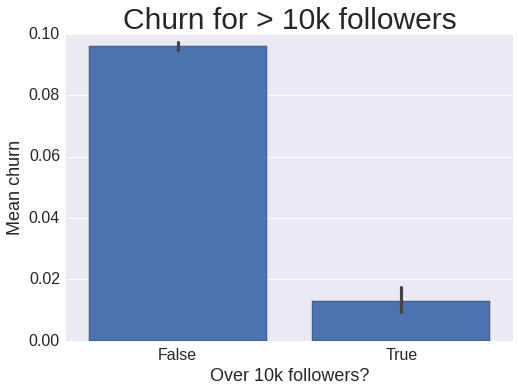

In [8]:
# num_followers
plt.figure(1)
spl = plt.subplot(111)
sns.violinplot(churn_df.log_followers, groupby=churn_df.churn)
plt.gca().set_title("No. of followers by churn status",size=30)
plt.gca().set_ylabel("Followers (log)",size=26)
plt.gca().set_xlabel("Churn",size=26)
spl.tick_params(axis='both',labelsize=20)


# num friends
plt.figure(2)
#print churn_df.log_friends.describe().isnull().any()
#print churn_df.log_friends.describe().replace([np.inf, -np.inf], np.nan).isnull().any()
#print churn_df.churn.isnull().any()
sns.violinplot(churn_df.log_friends.replace([np.inf, -np.inf], np.nan).dropna(), groupby=churn_df.churn)
plt.gca().set_ylabel("Friends (log)",fontsize=26)
plt.gca().set_title("No. of friends by churn status",size=30)
plt.gca().set_xlabel("Churn",size=26)
plt.gca().tick_params(axis='both',labelsize=20)

# churn by celebrity status
plt.figure(3)
churn_df['celebrity'] = churn_df.followers_count > 10000
sns.barplot(churn_df.celebrity, churn_df.churn)
plt.gca().set_title("Churn for > 10k followers",size=30)
plt.gca().set_xlabel("Over 10k followers?", size=18)
plt.gca().set_ylabel("Mean churn", size=18)
plt.gca().tick_params(axis='both',labelsize=16)

# both
print churn_df.shape
ff_df = churn_df[['log_followers','log_friends','churn']].replace([np.inf, -np.inf], np.nan).dropna()
#print np.histogram(np.concatenate([ff_df.log_followers, ff_df.log_friends]))

DescribeResult(nobs=18198, minmax=(-25.0, 957.0), mean=8.9846686449060336, variance=2431.5287532314087, skewness=9.232985565410093, kurtosis=107.68180706320277)
(4636,)
(4636, 2)
(4636, 3)


/home/patrick/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1206: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


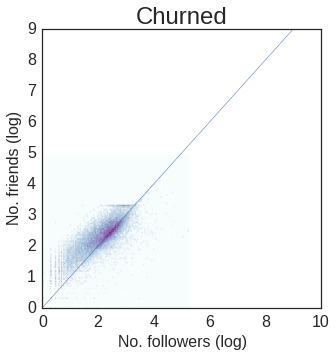

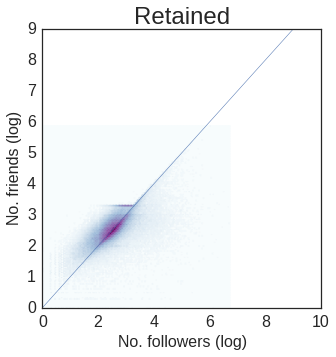

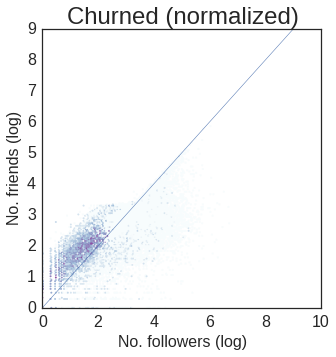

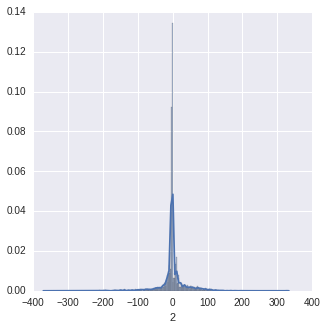

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

gridsize = 125

plt.figure(3)
with sns.axes_style("white"):
    ff_df2 = ff_df[ff_df.churn==True]
    #sns.jointplot(ff_df2.log_followers, ff_df2.log_friends, kind="hex", xlim=(0,12), ylim=(0,12))
    
    churned_plt = plt.hexbin(ff_df2.log_followers, ff_df2.log_friends, gridsize=gridsize, cmap=mpl.cm.BuPu, 
               norm=matplotlib.colors.PowerNorm(0.5))
    plt.gca().set_title("Churned",fontsize=24)
    plt.gca().tick_params(axis='both', labelsize=16)
    plt.gca().set_xlabel("No. followers (log)", size=16)
    plt.gca().set_ylabel("No. friends (log)", size=16)    
    plt.gca().set_xlim([0,10])
    plt.gca().set_ylim([0,9])
    plt.plot([0,10],[0,10],linewidth=0.5)
plt.savefig("../pics/churn_ff.png", dpi=300)
    
    
plt.figure(4)
with sns.axes_style("white"):
    ff_df3 = ff_df[ff_df.churn==False]
    retained_plt = plt.hexbin(ff_df3.log_followers, ff_df3.log_friends, gridsize=gridsize, cmap=mpl.cm.BuPu,
              norm=matplotlib.colors.PowerNorm(0.5))
    plt.gca().set_title("Retained",fontsize=24)
    plt.gca().tick_params(axis='both', labelsize=16)
    plt.gca().set_xlabel("No. followers (log)", size=16)
    plt.gca().set_ylabel("No. friends (log)", size=16)
    plt.gca().set_xlim([0,10])
    plt.gca().set_ylim([0,9])
    plt.plot([0,10],[0,10],linewidth=0.5)
plt.savefig("../pics/retain_ff.png", dpi=300)
     

print stats.describe(retained_plt.get_array() - churned_plt.get_array())
# difference hexbin
newx = np.concatenate((ff_df2.log_followers, ff_df3.log_followers))
newy = np.concatenate((ff_df2.log_friends, ff_df3.log_friends))
newc = np.concatenate((np.ones(ff_df2.log_friends.size)*
                       (float(ff_df3.log_friends.size)/float(ff_df2.log_friends.size)),
                       -1*np.ones_like(ff_df3.log_friends)))
#newc = np.concatenate((np.ones(ff_df2.log_friends.size)*
#                       (np.mean(retained_plt.get_array())/np.mean(churned_plt.get_array())),
#                       -1*np.ones_like(ff_df3.log_friends)))

plt.figure(5)
with sns.axes_style("white"):
    churn_norm = plt.hexbin(newx,newy,C=newc,reduce_C_function=np.sum, gridsize=gridsize, cmap=mpl.cm.BuPu,
              norm=matplotlib.colors.PowerNorm(0.5))
    plt.gca().tick_params(axis='both', labelsize=16)
    plt.gca().set_xlabel("No. followers (log)", size=16)
    plt.gca().set_ylabel("No. friends (log)", size=16)
    plt.gca().set_xlim([0,10])
    plt.gca().set_ylim([0,9]) 
    plt.gca().set_title("Churned (normalized)", fontsize=24)
    plt.plot([0,10],[0,10],linewidth=0.5)
plt.savefig("../pics/churn_norm.png", dpi=300)

    
# Linear models
print churn_norm.get_array().shape
print churn_norm.get_offsets().shape
pts_weights = pd.DataFrame(np.concatenate((churn_norm.get_offsets(),
                                           np.reshape(churn_norm.get_array(), (-1,1))), axis=1))

pts_weights[2] = pts_weights[2].replace([0,-np.inf, np.inf], np.nan)
pts_weights = pts_weights.dropna()

print pts_weights.shape
from sklearn.linear_model import Ridge
rreg = Ridge(alpha=1)

#print pts_weights[:,0].shape
#print pts_weights[:,1].shape
#print pts_weights[:,2].shape

#print pts_weights.describe()
plt.figure(6)
sns.distplot(pts_weights.iloc[:,2])

#plt.figure(5)
#a = pd.DataFrame(pts_weights.iloc[:,0])
#b = pts_weights.iloc[:,1]
#w = pts_weights.iloc[:,2] - pts_weights.iloc[:,2].min()
#w = w / w.max()
#print pts_weights.iloc[:,2].describe()
#print w.describe()
#rreg.fit(a,b,w)
#pts_line = rreg.predict(pd.DataFrame([0, 10]))
#plt.plot([0,10], pts_line)


count    201805.000000
mean         -0.093183
std           0.998158
min          -5.662960
25%          -0.636747
50%          -0.062738
75%           0.295815
max          14.066532
Name: friend_follow, dtype: float64


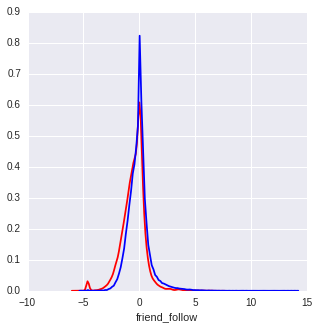

In [10]:
# More features
#friend_follow ratio, note NA strategy = 0
churn_df['friend_follow'] = (churn_df.followers_count / (churn_df.friends_count + 1)). \
        replace([np.inf, -np.inf, np.nan, 0], 0.01). \
        map(np.log)
#g = sns.FacetGrid(churn_df,col="churn")
#g.map(sns.distplot, "friend_follow")
sns.distplot(churn_df[churn_df.churn].friend_follow, color="red",hist=False)
sns.distplot(churn_df[churn_df.churn==False].friend_follow, color="blue",hist=False)
print churn_df.friend_follow.describe()

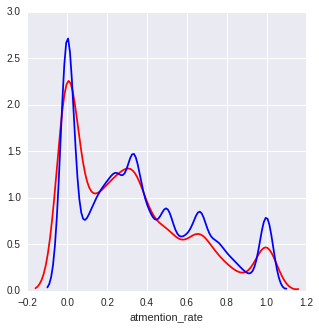

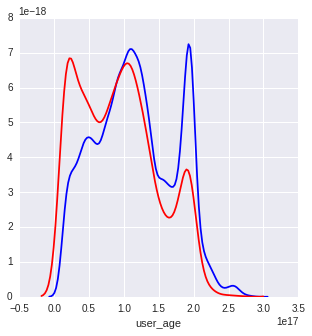

In [11]:
sns.distplot((churn_df[churn_df.churn & (churn_df.num_tweets_user >= 3)].atmention_rate), color="red",hist=False)
sns.distplot((churn_df[(~churn_df.churn) & (churn_df.num_tweets_user >= 3)].atmention_rate), color="blue",hist=False)

plt.figure(2)
sns.distplot((churn_df[(~churn_df.churn) & (churn_df.num_tweets_user >= 3)].user_age), color="blue",hist=False)
sns.distplot((churn_df[(churn_df.churn) & (churn_df.num_tweets_user >= 3)].user_age), color="red",hist=False)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import StratifiedKFold
import sklearn


# training-testing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

training, testing = train_test_split(churn_df[['churn','followers_count','friends_count',
                                               'user_age','friend_follow']].dropna(), 
                                     train_size=0.8, random_state=888)

In [13]:
training.isnull().any()

churn              False
followers_count    False
friends_count      False
user_age           False
friend_follow      False
dtype: bool

In [33]:
# make data pipeline
class LogScaler(sklearn.base.TransformerMixin):
    def __init__(self, base = 10, colnames=None):
        self.base = base
        self.colnames = colnames
        pass
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, copy=None, correction=0.01):
        """Log transform X or columns in X identified by
        colnames kwarg
        
        Arguments
        X         dataframe or numpy array to trasnform
        colnames  names of columns to transform
        base      base of log to transform, (10 if not given)
        """
        
        try:
            new_X_cols = np.log(X.loc[:,self.colnames].replace(0,correction)) / \
                                            np.log(self.base)
            new_X = pd.concat((X.loc[:,[c for c in X.columns if c not in self.colnames]],
                               new_X_cols),axis=1)[X.columns]
            #print new_X.head()
        except AttributeError, ValueError:
            new_X = np.log([np.max(x,correction) for x in X])/np.log(self.base)
        
        return new_X



logtransform = LogScaler(colnames=['followers_count','friends_count'])
print training.head()
print logtransform.fit_transform(training).head()
dscl = StandardScaler()
poly_feat = PolynomialFeatures(degree=3)
logreg = LogisticRegression(penalty='l1',class_weight='auto',C=1000)
logreg_pipeline = Pipeline([('logtrans', logtransform),
                            ('poly', poly_feat),
                            ('scaler', dscl),
                            ('logreg', logreg)])


#  once used to find C through k-fold CV
np.random.seed(888)
sample_size = 15000
sample_rows = np.random.choice(range(0, training.shape[0]), size=sample_size)
kfolds = StratifiedKFold(training.iloc[sample_rows,0], n_folds=5)
c_grid = [10 ** x for x in range(-3,5)]
f1_by_cval = {}

print training.iloc[sample_rows,:].replace([np.nan,np.inf,-np.inf], np.nan).isnull().any()

#gridfit = sklearn.grid_search.GridSearchCV(logreg_pipeline,
#                                       param_grid={'logreg__C': c_grid},
#                                       #scoring='precision',
#                                       cv=kfolds)
#gridfit.fit(training.iloc[sample_rows,1:],
#            training.iloc[sample_rows,0])
#f1_by_cval[cval] = f1ws
 
    
# Fit estimator pipeline or load one
#gridfit = logreg_pipeline
#gridfit.fit(training.iloc[sample_rows,1:],
#            training.iloc[sample_rows,0])
import pickle
gridfit = pickle.load(file("logreg_1435302860.pkl", "r"))

        churn  followers_count  friends_count            user_age  \
188832  False              519           1808   28158139000000000   
34464   False              393           1572  189987758000000000   
153028   True               92            181   72136005000000000   
35236    True              283            637  189479916000000000   
58977   False              325            224  160535886000000000   

        friend_follow  
188832      -1.248626  
34464       -1.386930  
153028      -0.682218  
35236       -0.812891  
58977        0.367725  
        churn  followers_count  friends_count            user_age  \
188832  False         2.715167       3.257198   28158139000000000   
34464   False         2.594393       3.196453  189987758000000000   
153028   True         1.963788       2.257679   72136005000000000   
35236    True         2.451786       2.804139  189479916000000000   
58977   False         2.511883       2.350248  160535886000000000   

        friend_follow  
18

In [15]:
#print training.iloc[161443,:]
#print logtransform.fit_transform(training).iloc[161443,:]
#print training.

In [16]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, \
    precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.learning_curve import learning_curve

#plots!


#logreg_best=gridfit.best_estimator_

# plot learning curve
def plot_learning_curve():
    sizes, train_score, test_score = learning_curve(gridfit, training.iloc[sample_rows,1:],
                            training.iloc[sample_rows,0], 
                            train_sizes=np.array([ 0.05, 0.1, 0.325, 0.4, 1.]))    # , 0.55, 0.7, 0.775, 1. 
    train_mean = np.mean(train_score, axis=1)
    train_std = np.std(train_score, axis=1)
    test_mean = np.mean(test_score, axis=1)
    test_std = np.std(test_score, axis=1)


    plt.fill_between(sizes, test_mean - test_std,
                         test_mean + test_std, alpha=0.1,
                         color="red")
    plt.fill_between(sizes, train_mean - train_std,
                         train_mean + train_std, alpha=0.1,
                         color="blue")
    plt.plot(sizes, test_mean, color='red',label="Testing accuracy")
    plt.plot(sizes, train_mean, color='blue',label="Training accuracy")
    plt.title("Learning Curve")
    plt.legend()

In [17]:
import pickle 
logreg_best = gridfit
logreg_best.score(testing.iloc[:,1:],testing.iloc[:,0])
#pickle.dump(logreg_best,file("logreg_{}.pkl".format(int(time.time())), "w"))`

0.67882361685785786

In [20]:
#print logreg_best._final_estimator.coef_
#print dir(poly_feat)
feat_names = pd.DataFrame(logreg_best.named_steps['poly'].powers_,columns=['followers_count','friends_count','user_age','follow_friend'])
logical_feat_names = [ ' * '.join([ z for z in [ feat_names.columns[y] + '^{}'.format(x[y]) for y in range(0,len(x)) ]
    if z.find("^0") == -1]) for _, x in feat_names.iterrows() ]

coef_df = pd.DataFrame({'feat': pd.Series(logical_feat_names),
                    'coef':pd.Series(logreg_best._final_estimator.coef_[0])})


coef_df['abs_coef'] = np.abs(coef_df.coef)
coef_df.sort('abs_coef')

,coef,feat,abs_coef
0,0.000000,,0.000000
23,0.075082,followers_count^1 * user_age^1 * follow_friend^1,0.075082
20,0.117855,followers_count^1 * friends_count^1 * user_age^1,0.117855
14,0.139038,follow_friend^2,0.139038
18,0.151934,followers_count^2 * follow_friend^1,0.151934
11,0.192404,friends_count^1 * follow_friend^1,0.192404
30,0.202591,friends_count^1 * follow_friend^2,0.202591
33,-0.348179,user_age^1 * follow_friend^2,0.348179
29,-0.402907,friends_count^1 * user_age^1 * follow_friend^1,0.402907
13,-0.431435,user_age^1 * follow_friend^1,0.431435


(0.15604544428560679, 0.54293193717277488, 0.24241715855297757, None)
[[25324 11217]
 [ 1746  2074]]


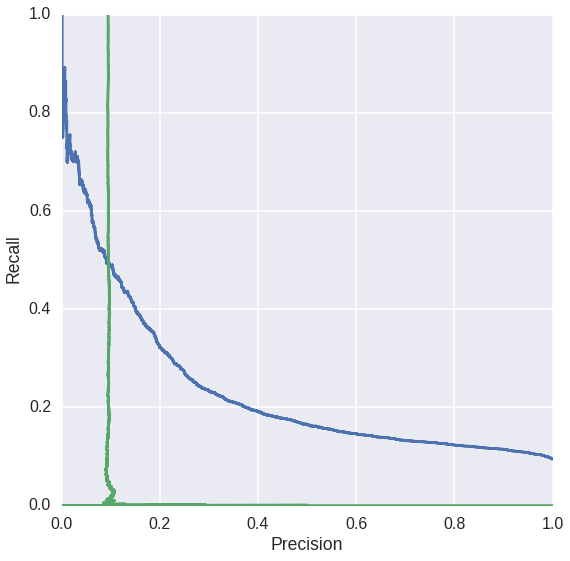

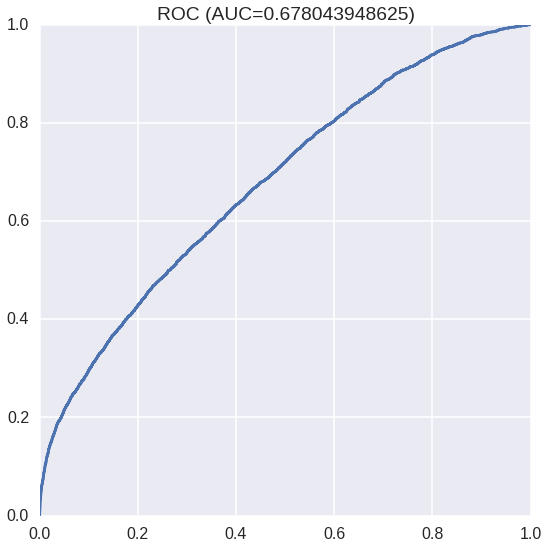

In [21]:
from sklearn.metrics import roc_auc_score
sns.set_context("poster")

prbs = zip(*logreg_best.predict_proba(testing.iloc[:,1:]))
prds = logreg_best.predict(testing.iloc[:,1:])
prs, rec, _ = precision_recall_curve(testing.iloc[:,0],prbs[1])
plt.plot(rec,prs)
prs2, rec2, _ = precision_recall_curve(testing.iloc[:,0],
                                       np.repeat(1, testing.shape[0])+np.random.normal(0,1,testing.shape[0]))
plt.plot(prs2,rec2)
plt.ylabel("Recall")
plt.xlabel("Precision")
plt.gca().set_aspect('equal')

plt.figure(2)
fpr, tpr, _ = roc_curve(testing.iloc[:,0],prbs[1])
plt.plot(fpr,tpr)
plt.gca().set_title("ROC (AUC={})".format(roc_auc_score(testing.iloc[:,0],prbs[1])))
plt.gca().set_aspect('equal')

print precision_recall_fscore_support(testing.iloc[:,0],prds,average='binary')
print confusion_matrix(testing.iloc[:,0],prds)

In [ ]:
def add_predictions_to_db(the_model):
    with con.cursor() as cur:
        for i, u in churn_df.iterrows():
            feats_user = pd.DataFrame(u[['followers_count', 'friends_count',
                                           'user_age','friend_follow']]).T
            try:
                prob_user = the_model.predict_proba(feats_user)[0][1]
            except ValueError:
                prob_user = 'NULL'
            
            cur.execute("UPDATE users SET churn_prob = {} WHERE user_id = '{}'".format(
                prob_user, u.user_id))
            con.commit()
            
print logreg_best.predict_proba(pd.DataFrame({'followers_count': 9765,
                                             'friends_count': 1211,
                                             'user_age': 291329218000000000,
                                             'friend_follow': 2.086533}, index=[1]))
con.rollback()
add_predictions_to_db(logreg_best)

In [ ]:
from sklearn.decomposition import PCA

#svm2 = pickle.load(file("svm1434693300.pkl","r"))

def plot_decision_boundary(svm, X, Y=None):
    """For the given dimensions (pick some),
    plot the decision boundary for SVM"""
    
    # do a PCA on X
    #print X.shape
    pca2 = PCA(2)
    x_prime = pca2.fit_transform(X)
    print pd.DataFrame(x_prime).describe()
    print pd.DataFrame(x_prime).drop_duplicates().shape
    
    # from sklearn example
    # Plot the decision boundary. For that, we will asign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    h = .02 
    x_min, x_max = x_prime[:, 0].min() - .5, x_prime[:, 0].max() + .5
    y_min, y_max = x_prime[:, 1].min() - .5, x_prime[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # transform back into original model space
    pca_coords = np.c_[xx.ravel(), yy.ravel()]
    prediction_coords = pca2.inverse_transform(pca_coords)
    Z = svm.predict(prediction_coords)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Blues)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    
    # plot points
    try:
        plt.scatter(x_prime[np.where(~Y),0], x_prime[np.where(~Y), 1], color=(1,0,1,0.1))
        plt.scatter(x_prime[np.where(Y),0], x_prime[np.where(Y), 1], color=(0,0,1,0.01))
    except TypeError:
        pass
    return pca2
    
plt.figure(1)
plot_decision_boundary(logreg_best, training_predictors[:,0:3], training.iloc[:,0])
plt.figure(2)
pca = plot_decision_boundary(logreg_best, training_predictors[:,0:3])
train_pca = pca.transform(training_predictors[:,0:3])

In [ ]:
plt.figure(3)
plt.scatter(train_pca[np.where(training.iloc[:,0]), 0], train_pca[np.where(training.iloc[:,0]),1])